In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST, CIFAR10

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix
from collections import Counter
from  pathlib import Path

from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("darkgrid")

# Image classification

Basic problem of handwritten digit classification. This notebook's purpose is to illustrate 'basic' image classification problems using Convolutional Neural Networks in PyTorch. We will tackle the MNIST classification problem (10 class, grayscale) and the CIFAR classification problem (10 class, RGB).

## MNIST classification

### 1. Load data

We will try the LeNet5 implementation at first which takes as input 32x32 grayscale images. The downloaded images are 28x28 so will pad them directly to get close to the setting of LeNet5.

Train data size : torch.Size([60000, 28, 28])
Test data size : torch.Size([10000, 28, 28])


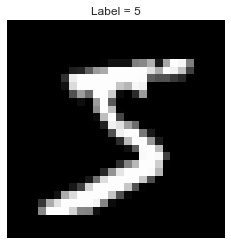

In [12]:
# MNIST labels
classes = np.arange(0, 9 + 1)

# By default the dtypes are PIL images, we transform them into tensors directly
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print(f"Train data size : {train_dataset.data.shape}")

test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(f"Test data size : {test_dataset.data.shape}")

# Visualize an example from the data
image, label = train_dataset[0]

plt.figure(figsize=(4, 4))
plt.title(f"Label = {label}")
plt.axis(False)
plt.imshow(np.array(image)[0], cmap='gray')
plt.show()

Let us look at the label counts in the training data to highlight potential imbalances that could affect the performance.

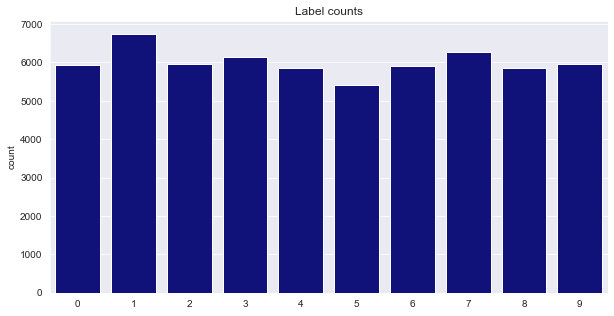

In [13]:
plt.title("Label counts")
sns.countplot(x = train_dataset.targets.numpy(), color = 'darkblue')
plt.show()

We have around 6000 examples of each class, but there is a slight imbalance.

### 2. Create model

#### 2.1 LeNet architecture ([LeCun et al., 1998])

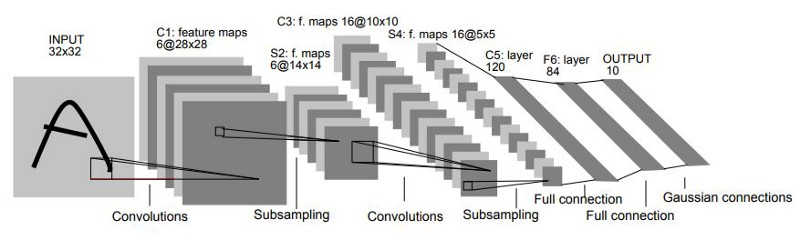

In [14]:
class LeNet(nn.Module):
    
    def __init__(self):
        
        super(LeNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        
        # Pooling and ReLu activations
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        # Flatten data
        x = x.view(-1, np.prod(x.size()[1:], axis=0))
        
        # Fully connected layers and ReLu activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Final softmax layer (use log softmax for better performance)
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

#### 2.2 Training process


Split training data into train/validation.

In [16]:
# Split data to get indices
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset.targets)), test_size=0.2, stratify=train_dataset.targets, random_state = 0)
                           
# Take subsets of the dataset (transforms are applied to the subsets)
train_dataset_sub = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset, val_indices)

# Pad data to go from 28x28 to 32x32 as required by our architecture
train_dataset.transform = transforms.Compose([
    transforms.Pad(2), 
    transforms.ToTensor()
])

# Find mean on train data
running_mean = 0.0
for data in train_dataset:
    image, _ = data
    running_mean += image.mean()
train_mean = running_mean / len(train_dataset)
    
# Find std on train data
running_msq = 0.0
for data in train_dataset:
    image, _ = data
    running_msq += ((image - train_mean)**2).mean()
train_std = torch.sqrt(running_msq / (len(train_dataset)))

# Add the normalization step to the transforms (subsets are also transformed)
train_dataset.transform = transforms.Compose([
    transforms.Pad(2), 
    transforms.ToTensor(),
    transforms.Normalize((train_mean, ), (train_std, ))
])

# Create loaders
train_loader_sub = torch.utils.data.DataLoader(train_dataset_sub, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

#### Fit model on training data

Train the model by checking the performance on validation data to spot when we start overfitting. Save the model for further usage.

In [22]:
def train(model, loss, optimize, n_epochs, train_loader, val_loader):
    
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
    
        train_running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            outputs = model(inputs)

            loss = loss_function(outputs, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_running_loss += loss.item()

        train_loss = train_running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Record perf on test data
        val_running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):

                inputs, labels = data
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        
        if epoch % 2 == 0:
            print(f"Epoch {epoch + 1} : train loss {train_loss:.5f} | val loss {val_loss:.5f}")
        
    return model, train_losses, val_losses

def save_model(model, file_name):
    path_to_model = Path(f"./models/{file_name}.pth")
    path_to_model.parents[0].mkdir(exist_ok = True, parents=True)
    torch.save(model.state_dict(), path_to_model)

#### Test different settings

In [23]:
model = LeNet()

# Negative log likelihood loss (for log proba inputs)
loss_function = nn.NLLLoss()

# Stochastic gradient descent
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Number of passes on full data
n_epochs = 20

# Train
model, train_losses, val_losses = train(model, loss_function, optimizer, n_epochs, train_loader_sub, val_loader)
    
# Save resulting model
save_model(model, "lenet5")

Epoch 1 : train loss 1.00388 | val loss 0.30486
Epoch 3 : train loss 0.16006 | val loss 0.14058
Epoch 5 : train loss 0.09637 | val loss 0.08671
Epoch 7 : train loss 0.07084 | val loss 0.07392
Epoch 9 : train loss 0.05664 | val loss 0.06416
Epoch 11 : train loss 0.04660 | val loss 0.05504
Epoch 13 : train loss 0.03956 | val loss 0.05415
Epoch 15 : train loss 0.03364 | val loss 0.04900
Epoch 17 : train loss 0.02918 | val loss 0.05408
Epoch 19 : train loss 0.02493 | val loss 0.05179


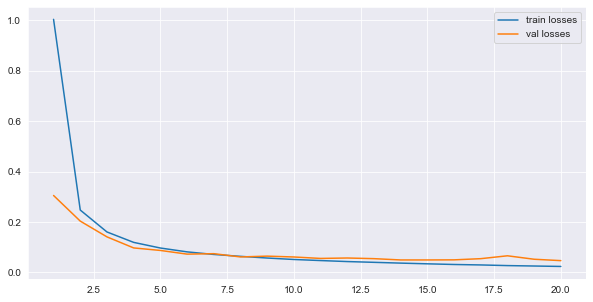

In [24]:
plt.plot(np.arange(1, n_epochs + 1), train_losses, label = "train losses")
plt.plot(np.arange(1, n_epochs + 1), val_losses, label = "val losses")
plt.legend()
plt.show()

#### Get performance of model on test data

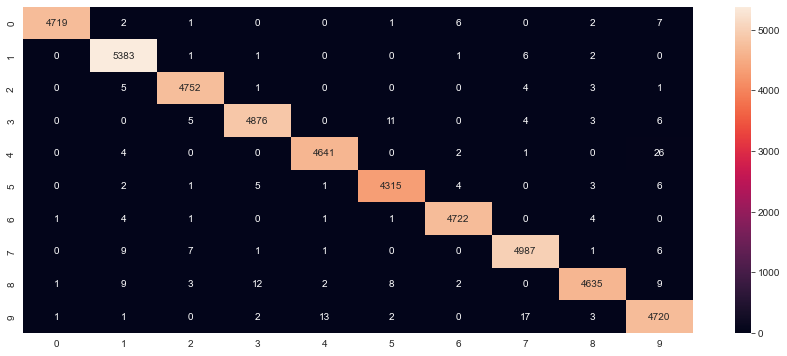

In [25]:
# Reload model 
model = LeNet()
model.load_state_dict(torch.load(Path(f"./models/lenet5.pth")))

train_labels = []
train_predictions = []
for i, data in enumerate(train_loader_sub, 0):
    
    inputs, labels = data
    train_labels += list(labels.numpy())
    
    outputs = model(inputs)
    train_predictions += list(outputs.max(axis=1).indices.numpy())
    
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.heatmap(confusion_matrix(train_labels, train_predictions), annot=True, fmt="d")
plt.show()

# CIFAR classification

In [26]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load data (By default the dtypes are PIL images, we transform them into tensors directly)
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f"Train data size : {train_dataset.data.shape}")
print(f"Test data size : {train_dataset.data.shape}")

Files already downloaded and verified
Files already downloaded and verified
Train data size : (50000, 32, 32, 3)
Test data size : (50000, 32, 32, 3)
